# Biophysical Variable Prediction in Scikit-Learn and Keras using PROSAIL Sentinel 2 Band Simulated Database
---

## Introduction
---

### Background
*Similar background to ALR paper*

### Objectives
The main objective of this paper is to compare the performance of SL2P(D) against the performance of a purely linear model which performs variable selection on the input bands, as well as the performance of the same linear model with the addition of a neural network which performs regression on the features selected by the linear model. In this case the feature selection will be performed by the least angle regression algorithm (Efron et al., 2002) provided by scikit-learn.

Specifically performance will be measured using the root mean squared error of each model as well as the absolute error in the model with respect to the specific true value of the response variables.

## Methodology
---

### Methods
Three methods were tested on the global PROSAIL dataset with 41472 samples simulated from various different biomes to estimate LAI, FCOVER, and FAPAR.
* SL2P
* LARS Regression
* LARS Regression + Keras (Tensorflow) Shallow Neural Network

The PROSAIL simulation generates Sentinel 2 bands:

| Band | Central Wavelength | Description | Resolution | 
|---|---|---|---|
| B3 | 560nm | green | 10m |
| B4 | 665nm | red | 10m |
| B5 | 705nm | VNIR | 20m res |
| B6 | 740nm | VNIR | 20m res |
| B7 | 783nm | VNIR | 20m res |
| B8A | 865nm | VNIR | 20m res |
| B11 | 1610nm | SWIR | 20m res |
| B12 | 2190nm | SWIR | 20m res |

*SL2P description* + `code`

In the script below the methodology used for LARS and the shallow neural network in Keras will be described further.

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy 
import pandas 
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
from tensorflow import keras 
import os
from scipy.stats import norm

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
matlabData = sio.loadmat(file_name='./data/s2_sl2p_uniform_sobol_prosail_inout.mat', variable_names=['Input', 'Output'])

In [4]:
inputDF = pandas.DataFrame(data=matlabData['Input']['Rho_Toc'][0][0])
inputAngles = pandas.DataFrame(data=matlabData['Input']['Angles'][0][0])

inputDF = pandas.concat([inputDF, inputAngles], axis=1, join='outer', ignore_index=True)
inputDF.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3']

LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

outputCSV = pandas.concat([inputDF, LAI, FAPAR, FCOVER], axis=1, join='outer')

outputCSV['latitude'] = 0
outputCSV['longitude'] = 0

outputCSV.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'latitude', 'longitude']

outputCSV

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,latitude,longitude
0,0.135065,0.036091,0.176256,0.560269,0.693070,0.700348,0.192899,0.053547,0.987754,0.798293,0.880581,7.373505,0.959376,0.994942,0,0
1,0.131110,0.039456,0.178036,0.439346,0.524225,0.557034,0.156434,0.046541,0.994753,0.850375,0.910160,5.851286,0.907860,0.951142,0,0
2,0.053260,0.048287,0.087601,0.310079,0.477312,0.491091,0.249131,0.122754,0.986242,0.923821,-0.997069,5.140015,0.804696,0.796222,0,0
3,0.114696,0.037035,0.150780,0.524558,0.666991,0.668328,0.202968,0.069788,0.972057,0.864255,-0.808992,3.730074,0.897923,0.924780,0,0
4,0.034735,0.037804,0.054668,0.102483,0.119924,0.124547,0.094616,0.081047,0.993655,0.696272,0.565758,2.190026,0.325828,0.316920,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,0.051041,0.023936,0.074248,0.290018,0.470453,0.529745,0.190576,0.085551,0.979996,0.649206,0.601609,10.775755,0.931971,0.934002,0,0
98300,0.114060,0.032969,0.153248,0.488660,0.635531,0.672578,0.218703,0.074495,0.964486,0.747298,0.647598,10.134769,0.961901,0.988942,0,0
98301,0.045267,0.031857,0.067163,0.258837,0.360417,0.373462,0.156660,0.075001,0.979186,0.605605,0.665831,4.748422,0.769665,0.771148,0,0
98302,0.066124,0.030878,0.092187,0.441620,0.618349,0.646669,0.167960,0.043700,0.992013,0.644762,-0.505298,5.171017,0.962452,0.983691,0,0


In [5]:
#outputCSV.to_csv(path_or_buf=r'rawFeatures.csv')

In [6]:
# Create probability distribution # 

N = numpy.linspace(0,outputCSV.shape[0],outputCSV.shape[0],dtype='int')

pdf = norm.pdf(N, loc=outputCSV.shape[0]/2, scale=outputCSV.shape[0]/6)

In [7]:
inputDF

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3
0,0.135065,0.036091,0.176256,0.560269,0.693070,0.700348,0.192899,0.053547,0.987754,0.798293,0.880581
1,0.131110,0.039456,0.178036,0.439346,0.524225,0.557034,0.156434,0.046541,0.994753,0.850375,0.910160
2,0.053260,0.048287,0.087601,0.310079,0.477312,0.491091,0.249131,0.122754,0.986242,0.923821,-0.997069
3,0.114696,0.037035,0.150780,0.524558,0.666991,0.668328,0.202968,0.069788,0.972057,0.864255,-0.808992
4,0.034735,0.037804,0.054668,0.102483,0.119924,0.124547,0.094616,0.081047,0.993655,0.696272,0.565758
...,...,...,...,...,...,...,...,...,...,...,...
98299,0.051041,0.023936,0.074248,0.290018,0.470453,0.529745,0.190576,0.085551,0.979996,0.649206,0.601609
98300,0.114060,0.032969,0.153248,0.488660,0.635531,0.672578,0.218703,0.074495,0.964486,0.747298,0.647598
98301,0.045267,0.031857,0.067163,0.258837,0.360417,0.373462,0.156660,0.075001,0.979186,0.605605,0.665831
98302,0.066124,0.030878,0.092187,0.441620,0.618349,0.646669,0.167960,0.043700,0.992013,0.644762,-0.505298


In [7]:
inputDF_centred = inputDF - inputDF.mean()
inputDF_normed = inputDF_centred * inputDF_centred.pow(2).sum().pow(-0.5)

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

LAI_centred = LAI.subtract(LAI_mean)
FAPAR_centred = FAPAR.subtract(FAPAR_mean)
FCOVER_centred = FCOVER.subtract(FCOVER_mean)

outputCSV_scaled = pandas.concat([inputDF_normed, LAI_centred, FAPAR_centred, FCOVER_centred], axis=1, join='outer')

outputCSV_scaled['prob'] = pdf

outputCSV_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'prob']

outputCSV_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,0.003986,-0.001124,0.003619,0.004843,0.003755,0.003451,-0.001399,-0.002884,0.001177,0.001679,0.003565,1.873505,0.179714,0.203224,2.704986e-07
1,0.003652,-0.000777,0.003736,0.001682,0.000509,0.000749,-0.002829,-0.003226,0.002966,0.002773,0.003689,0.351286,0.128198,0.159425,2.705481e-07
2,-0.002919,0.000133,-0.002199,-0.001696,-0.000393,-0.000494,0.000806,0.000493,0.000791,0.004316,-0.004275,-0.359985,0.025034,0.004504,2.705976e-07
3,0.002267,-0.001027,0.001947,0.003909,0.003254,0.002848,-0.001004,-0.002092,-0.002834,0.003065,-0.003490,-1.769926,0.118261,0.133063,2.706472e-07
4,-0.004482,-0.000947,-0.004361,-0.007121,-0.007264,-0.007405,-0.005254,-0.001542,0.002685,-0.000464,0.002251,-3.309974,-0.453834,-0.474798,2.706967e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,-0.003106,-0.002377,-0.003076,-0.002220,-0.000525,0.000235,-0.001490,-0.001323,-0.000805,-0.001452,0.002400,5.275755,0.152309,0.142284,2.707463e-07
98300,0.002213,-0.001446,0.002109,0.002971,0.002649,0.002928,-0.000387,-0.001862,-0.004768,0.000608,0.002592,4.634769,0.182239,0.197224,2.706967e-07
98301,-0.003594,-0.001560,-0.003541,-0.003035,-0.002641,-0.002712,-0.002820,-0.001837,-0.001012,-0.002368,0.002669,-0.751578,-0.009997,-0.020569,2.706472e-07
98302,-0.001833,-0.001661,-0.001898,0.001742,0.002319,0.002439,-0.002377,-0.003365,0.002266,-0.001545,-0.002222,-0.328983,0.182790,0.191973,2.705976e-07


In [8]:
training_data, valid_data = sklearn.model_selection.train_test_split(outputCSV_scaled, test_size=10000, train_size=50000, random_state=None, shuffle=True, stratify=None)

In [9]:
training_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
43624,0.006366,0.000103,0.006364,0.004565,0.003148,0.003464,0.002768,0.000035,0.003180,-0.001260,0.002772,1.698438,0.163928,0.194059,2.300223e-05
28323,-0.002083,-0.001957,-0.002259,0.001580,0.002627,0.002488,-0.002560,-0.003386,0.002013,0.003479,0.003963,3.008378,0.194478,0.201232,1.085264e-05
23217,-0.003505,-0.001666,-0.003553,-0.004957,-0.005190,-0.005212,-0.004785,-0.002935,0.003809,0.002734,-0.003265,-2.352040,-0.176320,-0.180438,6.956325e-06
18645,0.007001,0.000318,0.006874,0.004371,0.002872,0.003178,-0.000459,-0.001892,0.001416,0.003288,0.003644,1.426542,0.154376,0.190581,4.301614e-06
41803,-0.001545,-0.001917,-0.001736,0.002402,0.003704,0.003518,0.000919,-0.001265,0.000584,0.002292,0.003496,5.486713,0.194133,0.201565,2.201919e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36153,0.002864,-0.001245,0.002914,0.004910,0.004856,0.005404,0.004226,0.001297,-0.004960,0.003935,-0.003914,3.718439,0.183535,0.202168,1.777464e-05
56317,0.002481,0.002201,0.002296,0.002236,0.001166,0.001029,0.001482,0.000770,0.000244,-0.000964,0.002635,-3.421276,0.003882,0.001287,2.212899e-05
2981,0.002896,-0.001622,0.002470,0.004133,0.003681,0.003345,-0.001026,-0.002390,0.003050,0.000690,-0.002898,5.036277,0.177892,0.200211,4.592304e-07
85474,-0.002298,0.000983,-0.002156,-0.003015,-0.002912,-0.002862,-0.001472,-0.000181,0.003690,0.000292,-0.003162,-2.319583,-0.096433,-0.121488,2.085788e-06


In [10]:
valid_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
27861,-0.002832,-0.001637,-0.002983,-0.001245,-0.000223,-0.000117,-0.003633,-0.002985,0.001201,-0.005359,0.002239,-0.026370,0.120787,0.112063,1.046632e-05
1050,-0.001571,-0.001216,-0.001346,-0.000106,0.000067,0.000341,-0.001847,-0.001801,0.002013,-0.005120,0.001834,-1.343841,0.078196,0.077507,3.271680e-07
10823,-0.001856,-0.000453,-0.002003,-0.003131,-0.003056,-0.002764,-0.002751,-0.000301,-0.000815,0.003891,-0.003758,1.561499,0.027898,0.005958,1.577871e-06
41379,0.002078,0.010223,0.002646,-0.005082,-0.005817,-0.005740,0.002161,0.007204,0.004010,0.003043,-0.003919,-5.468283,-0.755782,-0.768937,2.175778e-05
26787,-0.002477,0.002551,-0.001447,-0.004703,-0.004850,-0.004493,-0.000056,0.002910,0.002813,0.003253,-0.004166,-3.516116,-0.352046,-0.390154,9.591037e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91560,-0.002945,-0.002647,-0.003314,-0.001439,0.000791,0.000527,0.001017,0.001015,-0.001564,-0.004498,-0.002146,2.974518,0.102453,0.094664,8.544125e-07
8040,0.009670,0.019443,0.008326,-0.002886,-0.004238,-0.004294,0.004892,0.012018,0.002455,-0.002810,0.002379,-5.477072,-0.760800,-0.775794,1.045270e-06
62961,-0.003002,-0.001952,-0.003159,0.000590,0.001971,0.002348,0.001038,-0.001157,-0.004699,-0.001619,-0.002505,0.955882,0.180067,0.185696,1.707007e-05
76939,-0.000329,0.004297,0.001871,-0.002397,-0.003435,-0.003570,0.000772,0.001286,0.003095,-0.003660,0.002158,-4.758873,-0.389416,-0.390014,5.779579e-06


In [11]:
training_data = training_data.reset_index(drop=True)

In [12]:
valid_data = valid_data.reset_index(drop=True)

In [13]:
#outputCSV_scaled.to_csv(path_or_buf=r'scaledFeatures.csv')

In [14]:
LAI_training = training_data['LAI']
FAPAR_training = training_data['FAPAR']
FCOVER_training = training_data['FCOVER']

In [15]:
LAI_valid = valid_data['LAI']
FAPAR_valid = valid_data['FAPAR']
FCOVER_valid = valid_data['FCOVER']

In [16]:
training_weights = numpy.array(training_data['prob'])
valid_weights = numpy.array(valid_data['prob'])

In [17]:
training_data = training_data.drop(['LAI', 'FAPAR', 'FCOVER','prob'], axis=1)
valid_data = valid_data.drop(['LAI', 'FAPAR', 'FCOVER','prob'], axis=1)

In [18]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [19]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [20]:
LAI_RMSE = sklearn.metrics.mean_squared_error(LAI_valid, LAI_predicted, squared=False)
FAPAR_RMSE = sklearn.metrics.mean_squared_error(FAPAR_valid, FAPAR_predicted, squared=False)
FCOVER_RMSE = sklearn.metrics.mean_squared_error(FCOVER_valid, FCOVER_predicted, squared=False)

In [21]:
print('LAI Coefficient Path - RMSE: {}'.format(LAI_RMSE))
pandas.DataFrame(LAImodel.coef_path_)

LAI Coefficient Path - RMSE: 2.5539889400129483


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-7.745002,58.109691,284.658735,-179.103154,-270.469758,-348.863554
1,0.0,-31.453376,-165.702759,-156.265527,-197.608926,-278.836702,-402.573750,-446.771750,-538.854020,-1005.084179,-1049.077402,-1086.820622
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1109.679770,1242.062928,1355.632627
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-197.211576,-778.738111,-2091.683898,-2160.687439,-2219.876075
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.000000,134.249384,272.022796,464.931774,652.865738,959.483974,1210.831482,1778.550051,3099.305075,3181.516747,3252.050114
6,0.0,0.000000,0.000000,0.000000,-313.372247,-659.782663,-1215.408437,-1384.488430,-1603.268641,-2310.434855,-2378.279020,-2436.506235
7,0.0,0.000000,0.000000,-141.872499,141.719758,513.843042,1108.839032,1280.233364,1492.891482,2200.529799,2270.113875,2329.838981
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
print('FAPAR Coefficient Path - RMSE: {}'.format(FAPAR_RMSE))
pandas.DataFrame(FAPARmodel.coef_path_)

FAPAR Coefficient Path - RMSE: 0.06905512093082193


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.486257
1,0.0,0.000000,-13.370767,-12.486855,-11.436608,-11.441878,-12.978848,-13.521306,-13.916900,-13.898240,-13.867110,-13.975563
2,0.0,0.000000,0.000000,0.000000,-1.051801,-2.525983,3.856546,5.597743,6.867433,6.852391,6.827388,7.334405
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-17.036595,-21.169705,-24.184414,-23.996839,-23.685461,-23.473418
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.033380,-8.066523,-10.994684
5,0.0,9.463106,22.833873,35.738031,36.835841,44.575267,58.815670,62.052816,64.414255,67.363039,72.256113,75.157613
6,0.0,0.000000,0.000000,0.000000,0.000000,-10.925004,-12.120519,-12.272497,-12.383850,-12.545113,-12.813189,-13.160285
7,0.0,0.000000,0.000000,-13.288088,-13.970678,-4.500413,-4.569920,-4.657248,-4.720317,-4.653268,-4.541593,-4.275658
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012231,0.020021
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
print('FCOVER Coefficient Path - RMSE: {}'.format(FCOVER_RMSE))
pandas.DataFrame(FCOVERmodel.coef_path_)

FCOVER Coefficient Path - RMSE: 0.2858357347347044


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.487332
1,0.0,0.000000,-13.690007,-13.834881,-11.864788,-11.147259,-10.996512,-12.225675,1.937322,9.100058,20.760663,49.468564
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-42.910288,-60.244999,-97.220114,-198.021529
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.731838,125.464130,170.238532,268.241836,418.541333
4,0.0,0.000000,0.000000,0.003378,-37.231714,-64.697527,-72.161156,-160.194472,-451.956538,-561.763035,-792.781918,-1167.154272
5,0.0,10.539886,24.229893,24.371421,76.316186,103.892273,111.562142,192.941762,403.817021,482.439196,649.700612,920.259182
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.323440,-5.983651,-23.657614,-29.355682,-51.900768,-71.794221
7,0.0,0.000000,0.000000,0.000000,-16.427206,-17.484847,-17.456037,-13.758472,-0.131892,3.310976,22.941971,36.991520
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [25]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [26]:
LAI_features = numpy.nonzero(LAImodel.coef_)[0]
FAPAR_features = numpy.nonzero(FAPARmodel.coef_)[0]
FCOVER_features = numpy.nonzero(FCOVERmodel.coef_)[0]

LAI_features = valid_data.columns[LAI_features]
FAPAR_features = valid_data.columns[FAPAR_features]
FCOVER_features = valid_data.columns[FCOVER_features]

In [29]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])

LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])

FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])

FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [30]:
LAI_history = LAI_model.fit(x = numpy.array(training_data), y = numpy.array(LAI_training), 
                            sample_weight = training_weights,
                            epochs = 100,
                            validation_data = (numpy.array(valid_data), numpy.array(LAI_valid), valid_weights) 
                           )

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 13s 252us/sample - loss: 1.0207e-04 - mse: 10.0533 - mae: 2.7495 - val_loss: 1.0099e-04 - val_mse: 9.8356 - val_mae: 2.7213
Epoch 2/100
50000/50000 [==============================] - 7s 143us/sample - loss: 6.9044e-05 - mse: 6.7946 - mae: 2.2225 - val_loss: 4.4446e-05 - val_mse: 4.3274 - val_mae: 1.7082
Epoch 3/100
50000/50000 [==============================] - 7s 143us/sample - loss: 4.2009e-05 - mse: 4.1406 - mae: 1.6572 - val_loss: 4.2150e-05 - val_mse: 4.0936 - val_mae: 1.6369
Epoch 4/100
50000/50000 [==============================] - 7s 145us/sample - loss: 4.0955e-05 - mse: 4.0360 - mae: 1.6274 - val_loss: 4.1081e-05 - val_mse: 4.0087 - val_mae: 1.6384
Epoch 5/100
50000/50000 [==============================] - 7s 144us/sample - loss: 3.9985e-05 - mse: 3.9373 - mae: 1.6067 - val_loss: 3.9723e-05 - val_mse: 3.8656 - val_mae: 1.6008
Epoch 6/100
50000/50000 [==================

In [31]:
FAPAR_history = FAPAR_model.fit(x = numpy.array(training_data), y = numpy.array(FAPAR_training),
                                sample_weight = training_weights,
                                epochs = 20, 
                                validation_data = (numpy.array(valid_data), numpy.array(FAPAR_valid), valid_weights)
                               )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 252us/sample - loss: 5.8780e-07 - mse: 0.0579 - mae: 0.1897 - val_loss: 5.7697e-07 - val_mse: 0.0562 - val_mae: 0.1912
Epoch 2/20
50000/50000 [==============================] - 8s 153us/sample - loss: 5.8525e-07 - mse: 0.0576 - mae: 0.1889 - val_loss: 5.7475e-07 - val_mse: 0.0559 - val_mae: 0.1816
Epoch 3/20
50000/50000 [==============================] - 8s 154us/sample - loss: 5.8306e-07 - mse: 0.0574 - mae: 0.1884 - val_loss: 5.7102e-07 - val_mse: 0.0556 - val_mae: 0.1835
Epoch 4/20
50000/50000 [==============================] - 8s 150us/sample - loss: 5.7978e-07 - mse: 0.0571 - mae: 0.1879 - val_loss: 5.6734e-07 - val_mse: 0.0552 - val_mae: 0.1871
Epoch 5/20
50000/50000 [==============================] - 8s 152us/sample - loss: 5.7546e-07 - mse: 0.0567 - mae: 0.1872 - val_loss: 5.6035e-07 - val_mse: 0.0545 - val_mae: 0.1821
Epoch 6/20
50000/50000 [=========================

In [32]:
FCOVER_history = FCOVER_model.fit(x = numpy.array(training_data), y = numpy.array(FCOVER_training),
                                  sample_weight = training_weights,
                                  epochs = 20, 
                                  validation_data = (numpy.array(valid_data), numpy.array(FCOVER_valid), valid_weights)
                                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 206us/sample - loss: 6.5197e-07 - mse: 0.0641 - mae: 0.2007 - val_loss: 6.3952e-07 - val_mse: 0.0622 - val_mae: 0.1958
Epoch 2/20
50000/50000 [==============================] - 7s 144us/sample - loss: 6.5052e-07 - mse: 0.0640 - mae: 0.2007 - val_loss: 6.3845e-07 - val_mse: 0.0621 - val_mae: 0.2002
Epoch 3/20
50000/50000 [==============================] - 7s 144us/sample - loss: 6.4885e-07 - mse: 0.0638 - mae: 0.2005 - val_loss: 6.3592e-07 - val_mse: 0.0619 - val_mae: 0.1961
Epoch 4/20
50000/50000 [==============================] - 7s 146us/sample - loss: 6.4603e-07 - mse: 0.0636 - mae: 0.1999 - val_loss: 6.3311e-07 - val_mse: 0.0616 - val_mae: 0.1998
Epoch 5/20
50000/50000 [==============================] - 7s 145us/sample - loss: 6.4152e-07 - mse: 0.0631 - mae: 0.1993 - val_loss: 6.2577e-07 - val_mse: 0.0609 - val_mae: 0.1973
Epoch 6/20
50000/50000 [=========================

In [33]:
LAI_predictions = pandas.Series(LAI_model.predict(numpy.array(valid_data)).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(numpy.array(valid_data)).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(numpy.array(valid_data)).flatten())

In [34]:
xy_skl_LAI = numpy.vstack([LAI_valid, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI_valid, LAI_predictions])

xy_skl_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predictions])

xy_skl_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predictions])

In [35]:
z_skl_LAI = scipy.stats.gaussian_kde(xy_skl_LAI)(xy_skl_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

z_skl_FAPAR = scipy.stats.gaussian_kde(xy_skl_FAPAR)(xy_skl_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)

z_skl_FCOVER = scipy.stats.gaussian_kde(xy_skl_FCOVER)(xy_skl_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [36]:
idx_skl_LAI = z_skl_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()

idx_skl_FAPAR = z_skl_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()

idx_skl_FCOVER = z_skl_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [37]:
x_skl_LAI = LAI_valid[idx_skl_LAI]
x_tf_LAI = LAI_valid[idx_tf_LAI]

x_skl_FAPAR = FAPAR_valid[idx_skl_FAPAR]
x_tf_FAPAR = FAPAR_valid[idx_tf_FAPAR]

x_skl_FCOVER = FCOVER_valid[idx_skl_FCOVER]
x_tf_FCOVER = FCOVER_valid[idx_tf_FCOVER]

In [38]:
y_skl_LAI = LAI_predicted[idx_skl_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]

y_skl_FAPAR = FAPAR_predicted[idx_skl_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]

y_skl_FCOVER = FCOVER_predicted[idx_skl_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [39]:
z_skl_LAI = z_skl_LAI[idx_skl_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

z_skl_FAPAR = z_skl_FAPAR[idx_skl_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]

z_skl_FCOVER = z_skl_FCOVER[idx_skl_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [40]:
rmse_skl_LAI = sklearn.metrics.mean_squared_error(x_skl_LAI, y_skl_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

rmse_skl_FAPAR = sklearn.metrics.mean_squared_error(x_skl_FAPAR, y_skl_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)

rmse_skl_FCOVER = sklearn.metrics.mean_squared_error(x_skl_FCOVER, y_skl_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.04877401604452429')

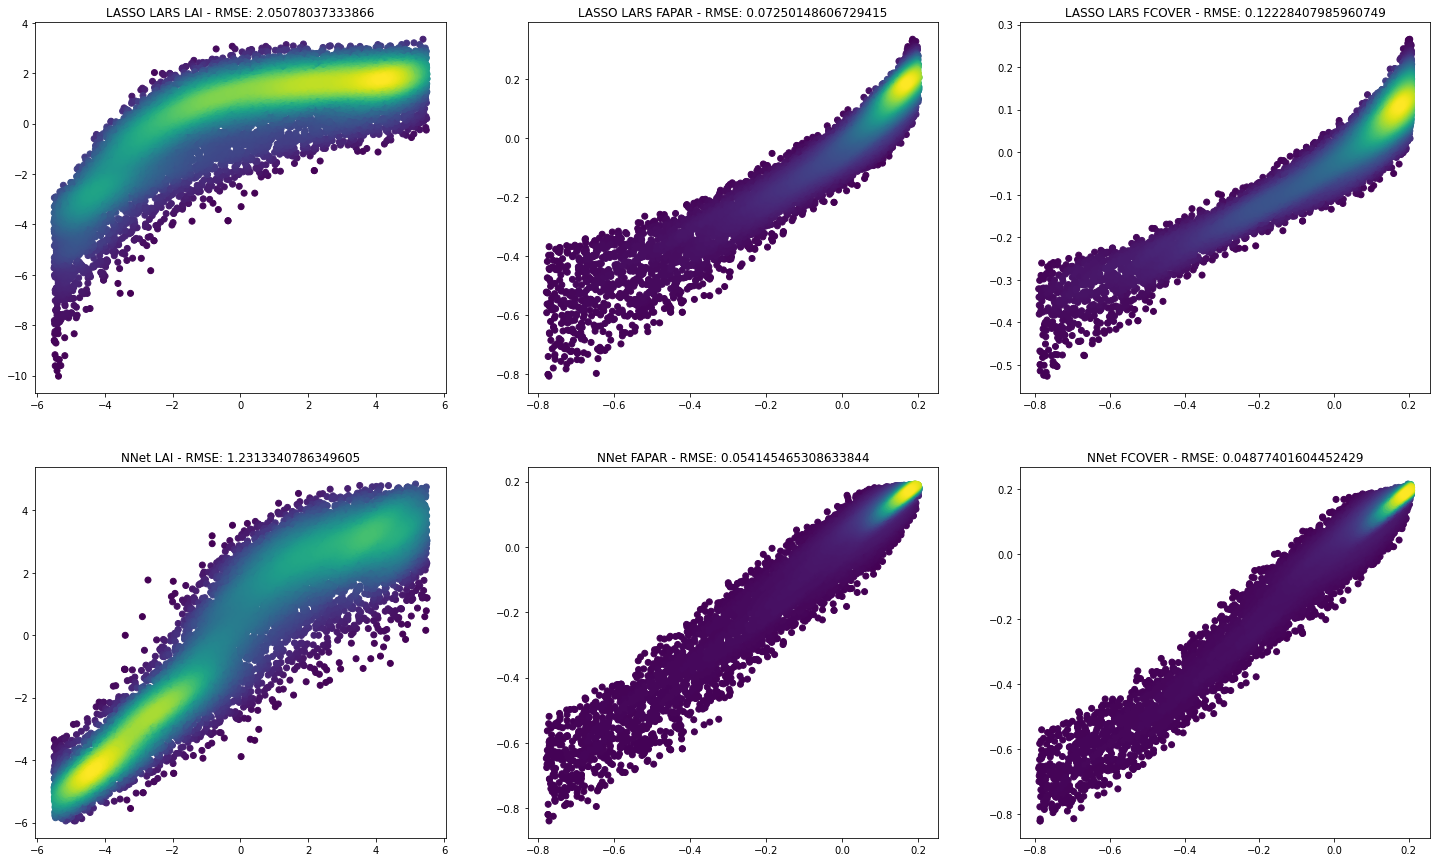

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))

ax[0,0].scatter(x_skl_LAI, y_skl_LAI, c=z_skl_LAI)
ax[0,0].set_title('LASSO LARS LAI - RMSE: {}'.format(rmse_skl_LAI))

ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))

ax[0,1].scatter(x_skl_FAPAR, y_skl_FAPAR, c=z_skl_FAPAR)
ax[0,1].set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_skl_FAPAR))

ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))

ax[0,2].scatter(x_skl_FCOVER, y_skl_FCOVER, c=z_skl_FCOVER)
ax[0,2].set_title('LASSO LARS FCOVER - RMSE: {}'.format(rmse_skl_FCOVER))

ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))

#plt.savefig("./matplotlib_outputs/uniform_replicates_w_weights_50000_samples_all_features.jpg")

In [ ]:
LAI_rmse = plt.plot(numpy.sqrt(LAI_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("LAI RMSE")
plt.show()

In [ ]:
FAPAR_rmse = plt.plot(numpy.sqrt(FAPAR_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("FAPAR RMSE")
plt.show()

In [ ]:
FCOVER_rmse = plt.plot(numpy.sqrt(FCOVER_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("FCOVER RMSE")
plt.show()

In [ ]:
import ee
ee.Initialize()

In [ ]:
def EE_LARS_Regression(assetName, features, response, maxSamples, n_nonzero):
        
    inputCSV = ee.FeatureCollection(assetName)
    inputCSV = inputCSV.toList(count=maxSamples)
    
    def extractBands(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=features).toList()

    def extractVI(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=[response]).toList()
    
    inputList = inputCSV.map(extractBands)
    outputList = inputCSV.map(extractVI)
    
    X = ee.Array(inputList)
    y = ee.Array(outputList)
    
    n = X.length().get([0])
    m = X.length().get([1])
    
    
    def centre(output):
        output = ee.Array(output)
        mean = output.reduce(ee.Reducer.mean(), [0]).get([0,0])
        return output.subtract(mean)
        
    def normalize(inputs):
        inputs = ee.Array(inputs)
        
        inputMeans = inputs.reduce(ee.Reducer.mean(), [0])
        inputMeans = inputMeans.repeat(0, n)
        inputs = inputs.subtract(inputMeans)
        inputs = inputs.pow(2).reduce(ee.Reducer.sum(), [0]).pow(-0.5).repeat(0,n).multiply(inputs)
        
        return inputs
    
    X = normalize(X)
    y = centre(y)
    
    def LARSregression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        prediction = inputs.getArray('prediction')
        coeff_arr = inputs.getArray('coeff_arr')
    
        c = X.matrixTranspose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())

        maxLocs = c_abs.gte(C_max.subtract(0.00001))
        signs = c.divide(c_abs)

        signs_j = maxLocs.multiply(signs).matrixTranspose()
        signs_jc = signs_j.abs().subtract(1).multiply(-1)
        
        A = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_j).toList().get(0))
        A_c = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_jc).toList().get(0))

        signMatrix_j = signs_j.repeat(0, n)

        X_A = X.multiply(signMatrix_j).mask(signs_j)
        j = X_A.length().get([1])
        
        G_A = X_A.matrixTranspose().matrixMultiply(X_A)

        V1_A = ee.Array(ee.List.repeat([1], j))

        G_Ai = G_A.matrixInverse()

        A_A = V1_A.matrixTranspose().matrixMultiply(G_Ai).matrixMultiply(V1_A).get([0,0]).pow(-0.5)

        w_A = G_Ai.matrixMultiply(V1_A).multiply(A_A)

        u_A = X_A.matrixMultiply(w_A)

        a = X.matrixTranspose().matrixMultiply(u_A)

        def computeGammaRRay(index_j):
            minus_j = C_max.subtract(c.get([index_j, 0])).divide(A_A.subtract(a.get([index_j, 0])))
            plus_j = C_max.add(c.get([index_j, 0])).divide(A_A.add(a.get([index_j, 0])))

            gammaRRay = ee.Array([minus_j, plus_j]);
            gammaRRay = gammaRRay.mask(gammaRRay.gte(0))
            gammaRRay = gammaRRay.multiply(-1)

            return gammaRRay.get(gammaRRay.argmax())

        gammaRRay = ee.Array([A_c.map(computeGammaRRay)])
        gamma = gammaRRay.get(gammaRRay.argmax()).multiply(-1)

        prediction = prediction.add(u_A.multiply(gamma))
        coefficients = X.matrixSolve(prediction)

        def setZero(num):
            num = ee.Number(num)
            return ee.Algorithms.If(num.abs().lt(0.0000000001), [0], [num])

        coefficients = ee.Array(ee.List(coefficients.matrixTranspose().toList().get(0)).map(setZero))

        coeff_arr = ee.Array.cat([coeff_arr, coefficients], axis=1)

        outputs = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

        return outputs
    
    
    numIterations = ee.List.sequence(1, n_nonzero)
    prediction = ee.Array(ee.List.repeat([0], n))
    coeff_arr = ee.Array(ee.List.repeat([0], m))
    initial = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

    finalOutputs = numIterations.iterate(LARSregression, initial)
    finalOutputs = ee.Dictionary(finalOutputs)
    finalPrediction = finalOutputs.getArray('prediction')

    coeff_arr = finalOutputs.getArray('coeff_arr')
    coeff_arr = coeff_arr.getInfo()
    coeff_arr = numpy.asarray(coeff_arr)
    
    return coeff_arr

In [ ]:
LAI_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                              ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'], 
                              'LAI', 
                              50000, 
                              10)

In [ ]:
FAPAR_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures',
                                ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                'FAPAR', 
                                50000, 
                                10)

In [ ]:
FCOVER_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                                 ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                 'FCOVER', 
                                 50000, 
                                 10)

In [ ]:
LAI_coef = pandas.DataFrame(LAI_coef)
FAPAR_coef = pandas.DataFrame(FAPAR_coef)
FCOVER_coef = pandas.DataFrame(FCOVER_coef)

In [ ]:
LAI_coef

In [ ]:
FAPAR_coef

In [ ]:
FCOVER_coef